# CPS 840 / CP 8318 Assignment 2
## CPS 840 [30 Marks]
## CP 8318 [36 Marks]

## Import libraries

In [65]:
import numpy as np # NumPy functionality
import matplotlib.pyplot as plt # Plotting
from sklearn.naive_bayes import ComplementNB, BernoulliNB # Naive Bayes
from sklearn.linear_model import LogisticRegression # Logistic Regression
from sklearn.svm import LinearSVC, SVC # Support Vector Machine Classifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.decomposition import PCA # Principle Component Analysis (PCA)
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA # Linear Discriminant Analysis (LDA)
from sklearn.metrics import accuracy_score, log_loss, confusion_matrix # Cost/Error/etc functions
import seaborn as sn # Used for plotting heatmaps
import pandas as pd # Used to create Dataframes
import warnings; warnings.simplefilter('ignore') # Ignore Warnings

# To go from many binaries to index based scalar
def binary_to_scalar(arr):
    return np.array([np.argmax(x) for x in arr])

emotions = ["angry","disgust","fear","happy","sad","surprise","nuetral"]

## Load dataset

In [66]:
trainingset = np.loadtxt('training.csv', delimiter=',')
testingset = np.loadtxt('test.csv', delimiter=',')

## Split data

In [67]:
n_inputs = 2304 # images are 48 x 48
n_classes = 7 # 7 classes - as defined below
img_dim = 48 # each input image dimension, width and height are both 48

x_training = trainingset[:, 0:n_inputs] # Extract the first 2304 elements - the image
y_training = trainingset[:, n_inputs:n_inputs + n_classes] # Extract the last 7 elements - a one hot category encoding

x_testing = testingset[:, 0:n_inputs] # Extract the first 2304 elements - the image
y_testing = testingset[:, n_inputs:n_inputs + n_classes] # Extract the last 7 elements - a one hot category encoding

x_training = x_training.reshape(x_training.shape[0], 48, 48) # Make samples image shaped
x_testing = x_testing.reshape(x_testing.shape[0], 48, 48) # Make samples image shaped

In [68]:
def get_emotion(whichemotion):
    if whichemotion.shape[0] == 1:
        indx = whichemotion[0]
    else:
        indx = np.argmax(whichemotion)
    if indx == 0:
        return 'angry'
    elif indx == 1:
        return 'disgust'
    elif indx == 2:
        return 'fear'
    elif indx == 3:
        return 'happy'
    elif indx == 4:
        return 'sad'
    elif indx == 5:
        return 'surprise'
    elif indx == 6:
        return 'neutral'

(28709, 48, 48)
(28709, 7)
(3589, 48, 48)
(3589, 7)


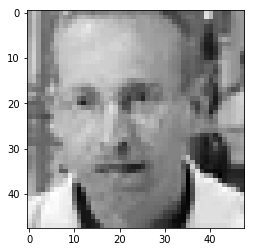

781
facial emotion: neutral


In [69]:
print(x_training.shape)
print(y_training.shape)

print(x_testing.shape)
print(y_testing.shape)

sampleindex = np.random.randint(0,1000)
sample = x_training[sampleindex,:]

plt.imshow(sample, cmap='gray')
plt.show()
print(sampleindex)
print('facial emotion: %s' % get_emotion(y_training[sampleindex, :]))

# Part I : Happy or Sad

## For this part you will consider a binary classification problem - categorizing faces as happy or sad

[1 Mark] a. Sample from the data loaded above to include only the happy or sad cases

In [70]:
sh_train_y = y_training[(y_training[:,3] == 1) | (y_training[:,4] == 1),:]
sh_train_x = x_training[(y_training[:,3] == 1) | (y_training[:,4] == 1),:]

sh_test_y = y_testing[(y_testing[:,3] == 1) | (y_testing[:,4] == 1),:]
sh_test_x = x_testing[(y_testing[:,3] == 1) | (y_testing[:,4] == 1),:]

# Flatten the training/testing image pixel set
sh_train_x_flat = sh_train_x.reshape(sh_train_x.shape[0],sh_train_x.shape[1]*sh_train_x.shape[2])
sh_test_x_flat = sh_test_x.reshape(sh_test_x.shape[0],sh_train_x.shape[1]*sh_train_x.shape[2])

# Get the binary results
sh_train_y_flat = binary_to_scalar(sh_train_y)
sh_test_y_flat = binary_to_scalar(sh_test_y)

[4 Marks] b. Apply PCA and LDA to represent the faces, display a sample of a few faces for each case. You may consider using one or both of these in the steps that follow if they are of any value (this is for you to decide).

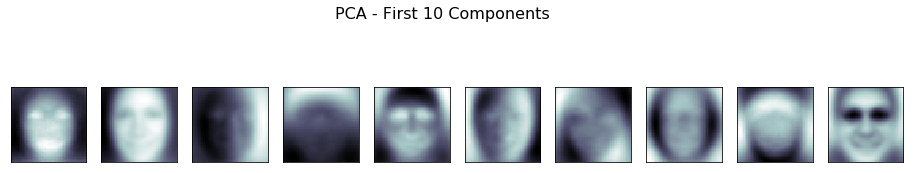

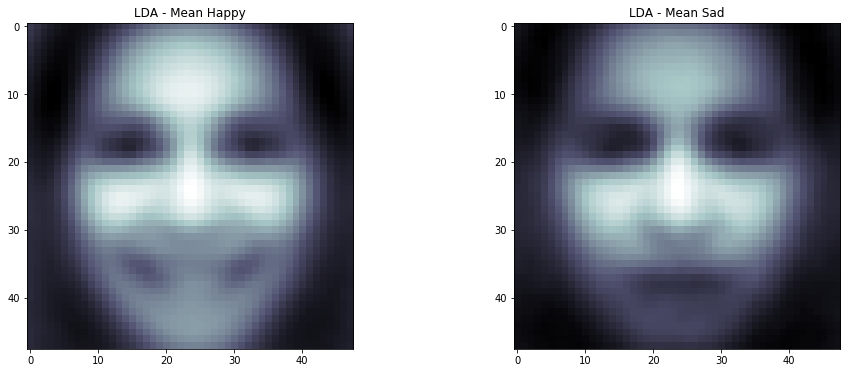

In [72]:
# Apply Principle Component Analysis
pca = PCA(n_components=64,whiten=True)
pca.fit(sh_train_x_flat)
cvar_p1 = [pca.explained_variance_[:i+1].sum() for i in range(len(pca.explained_variance_))]

# Show faces from first element to the tenth
fig = plt.figure(figsize=(16, 6))
fig.suptitle('PCA - First 10 Components', fontsize=16)
for i in range(10):
    ax = fig.add_subplot(2, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape(sh_train_x.shape[1],sh_train_x.shape[2]),
              cmap=plt.cm.bone)
plt.show()

# LDA
lda = LDA()
sh_train_x_lda = lda.fit_transform(sh_train_x_flat, sh_train_y_flat)

# Get the class means
faces = lda.means_.reshape(2, 48, 48)

# Show the means of both happy and sad
fig = plt.figure(figsize=(16,6))
ax = fig.add_subplot(121)
ax.imshow(faces[0],cmap=plt.cm.bone)
ax.set_title("LDA - Mean Happy")
ax = fig.add_subplot(122)
ax.imshow(faces[1],cmap=plt.cm.bone)
ax.set_title("LDA - Mean Sad")
fig.show()

[2 Marks] c. Apply naive Bayes to classify faces as happy or sad. Report your accuracy.

In [285]:
# Instantiate Naive Bayes
nb = BernoulliNB()
# Train the model using our training data
nb.fit(sh_train_x_flat, sh_train_y_flat)

BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)

In [286]:
# Get the prediction for the testing data
sh_test_pred = nb.predict(sh_test_x_flat)
# Print the accuracy of the model
print("Accuracy Score (accuracy_score): %0.2f" % accuracy_score(sh_test_y_flat, sh_test_pred))
# Print the cross entripy of the model
print("Cross Entripy (log_loss): %0.2f" % log_loss(sh_test_y_flat, nb.predict_proba(sh_test_x_flat)))

Accuracy Score (accuracy_score): 0.57
Cross Entripy (log_loss): 5.05


[2 Marks] d. Apply Logistic regression to classify faces as happy or sad. Report the accuracy.

In [287]:
# Instantiate Logistic Regression Classification
lr = LogisticRegression(solver='lbfgs')
# Train the model using our training data
lr.fit(sh_train_x_flat, sh_train_y_flat)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [288]:
# Get the prediction for the testing data
sh_test_pred = lr.predict(sh_test_x_flat)
# Print the accuracy of the model
print("Accuracy Score (accuracy_score): %0.2f" % accuracy_score(sh_test_y_flat, sh_test_pred))
# Print the cross entripy of the model
print("Cross Entripy (log_loss): %0.2f" % log_loss(sh_test_y_flat, lr.predict_proba(sh_test_x_flat)))

Accuracy Score (accuracy_score): 0.70
Cross Entripy (log_loss): 0.60


[2 Marks] e. Apply a Support Vector Machine to classify the faces as happy or sad. Choose parameters / arguments to try to maximize your accuracy. Report the accuracy.

In [289]:
# Instantiate Support Vector Machine Classifier
svc = LinearSVC()
# Train the model using our training data
svc.fit(sh_train_x_flat, sh_train_y_flat)

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

In [290]:
# Get the prediction for the testing data
sh_test_pred = svc.predict(sh_test_x_flat)
# Print the accuracy of the model
print("Accuracy Score (accuracy_score): %0.2f" % accuracy_score(sh_test_y_flat, sh_test_pred))
# Print the cross entripy of the model
print("Cross Entripy (log_loss): %0.2f" % log_loss(sh_test_y_flat, svc.decision_function(sh_test_x_flat)))

Accuracy Score (accuracy_score): 0.63
Cross Entripy (log_loss): 7.65


[1 Mark] f. Which of the approaches above allow you to reliably determine the degree of happiness or sadness (i.e. how happy or how sad)? Which do you trust the most?

            According to the accuracy_score and log_loss values resulted above, the most reliable method (best predictor) seems to be the Logistic Regression Classifier.

[2 Marks] g. Based on your answer to f. show the 5 happiest faces and the 5 saddest faces.

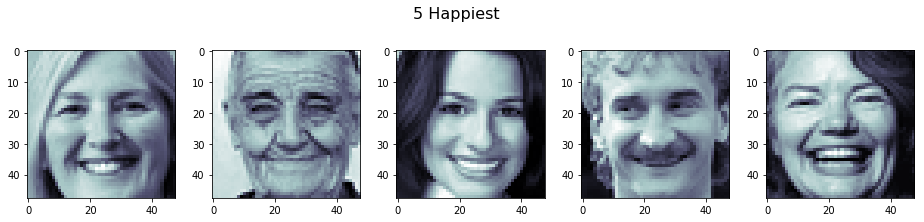

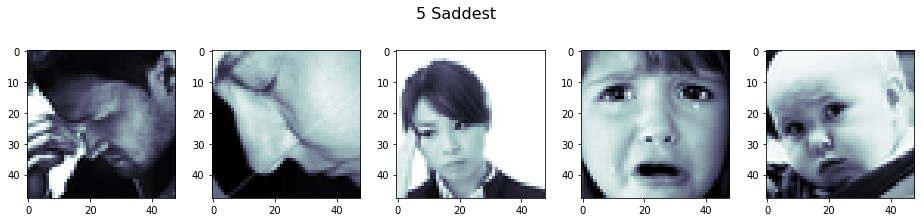

In [11]:
# Get predictions using model once more
prob_test = lr.predict_proba(sh_test_x_flat)
happy_five = np.argpartition(prob_test[:, 0], -5)[-5:]
sad_five = np.argpartition(prob_test[:, 1], -5)[-5:]

# Show the 5 happiest faces
fig = plt.figure(figsize=(16, 6))
fig.suptitle('5 Happiest', fontsize=16)
for i in range(5):
    ax = fig.add_subplot(2, 5, i + 1)
    ax.imshow(sh_test_x[happy_five[i]],cmap=plt.cm.bone)
plt.show()

# Show the 5 saddest faces
fig = plt.figure(figsize=(16, 6))
fig.suptitle('5 Saddest', fontsize=16)
for i in range(5):
    ax = fig.add_subplot(2, 5, i + 1)
    ax.imshow(sh_test_x[sad_five[i]],cmap=plt.cm.bone)
plt.show()

# Part II : Multi-class

## For this part you will repeat the tasks in Part I, but instead consider the multi-class problem and classify inputs according to all 7 classes. 

In [108]:
# Flatten the input data
x_training_flat = x_training.reshape(x_training.shape[0],x_training.shape[1]*x_training.shape[2])
x_testing_flat = x_testing.reshape(x_testing.shape[0],x_testing.shape[1]*x_testing.shape[2])

# Flatten the y values
y_training_flat = binary_to_scalar(y_training)
y_testing_flat = binary_to_scalar(y_testing)

[4 Marks] a. Apply PCA and LDA to represent the faces, display a sample of a few faces for each case. Produce a plot for PCA showing the cumulative variance captured by adding additional principal components (e.g. 1st PC, 1st + 2nd PC, etc.). On the same figure, plot the same curve for only happy and sad faces used in part 1.

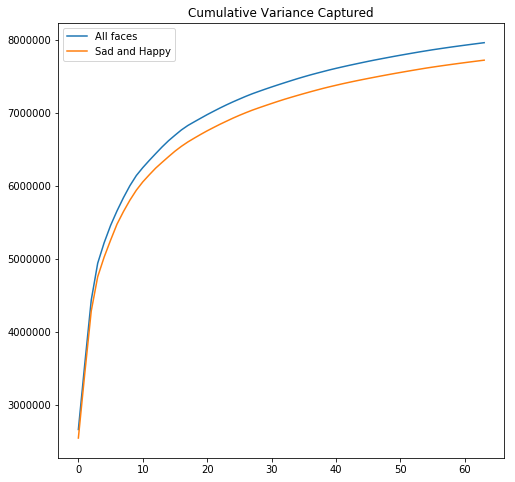

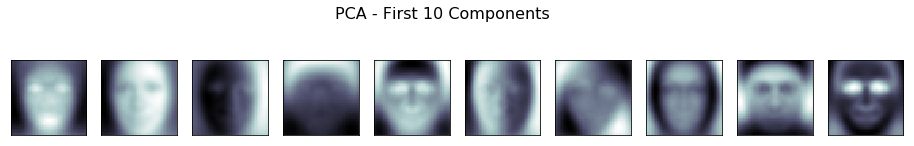

In [111]:
# Apply Principle Component Analysis
pca = PCA(n_components=64,whiten=True)
pca.fit(x_training_flat)
# Get and plot cumulitive variance
cvar = [pca.explained_variance_[:i+1].sum() for i in range(len(pca.explained_variance_))]
plt.figure(figsize=(8,8))
plt.title("Cumulative Variance Captured")
plt.plot(range(len(pca.explained_variance_)),cvar, label="All faces")
plt.plot(range(len(pca.explained_variance_)),cvar_p1, label="Sad and Happy")
plt.legend(loc='best')
plt.show()

# Show faces from first element to the tenth
fig = plt.figure(figsize=(16, 6))
fig.suptitle('PCA - First 10 Components', fontsize=16)
for i in range(10):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape(x_training.shape[1],x_training.shape[2]),
              cmap=plt.cm.bone)
plt.show()

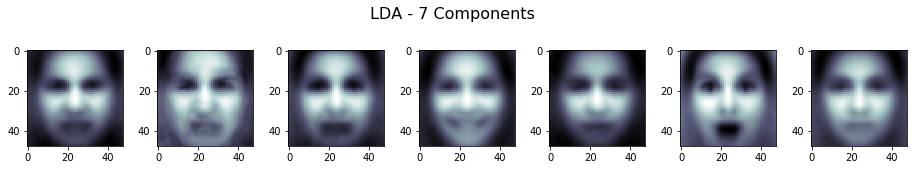

In [112]:
# LDA
lda = LDA()
lda.fit(x_training_flat, y_training_flat)

# Get the class means
faces = lda.means_.reshape(7, 48, 48)

# Show the faces
fig = plt.figure(figsize=(16,6))
fig.suptitle('LDA - 7 Components', fontsize=16)
for i in range(7):
    ax = plt.subplot(3, 7, i+1)
    ax.imshow(faces[i],cmap=plt.cm.bone)
fig.show()

[2 Marks] b. Classify the faces using Naive Bayes and report your accuracy.

In [113]:
# Instantiate Naive Bayes
nb = ComplementNB()
# Train the model using our training data
nb.fit(x_training_flat, y_training_flat)

ComplementNB(alpha=1.0, class_prior=None, fit_prior=True, norm=False)

Visualize the results of your classifier on the test set using a confusion matrix. Describe briefly how the multi-class nature of the problem is treated by the classifier.

<pre>Naive bayes has to keep track probabilities for all the classes in a multiclass problem. The problem expands out to n number of probabilities per feature given n is the number of classes. Since naive bayes is inherently multiclass, SKLearn doesn't have to do anything to accomodate for multiclass.</pre>

Accuracy Score (accuracy_score): 0.26
Cross Entripy (log_loss): 1.69


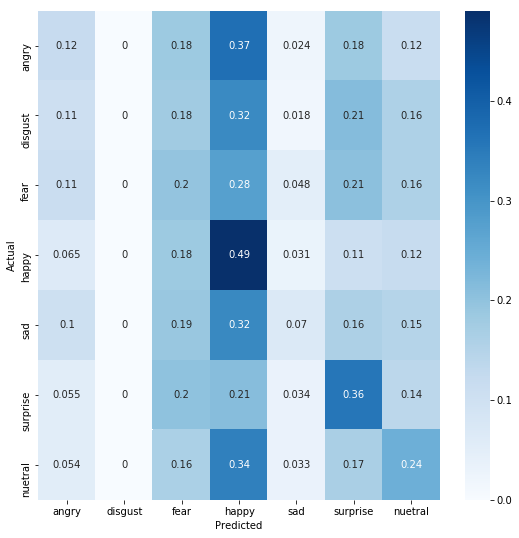

In [173]:
# Get the prediction for the testing data
y_pred_nb = nb.predict(x_testing_flat)
y_pred_nbp = nb.predict_proba(x_testing_flat)
# Print the accuracy of the model
print("Accuracy Score (accuracy_score): %0.2f" % accuracy_score(y_testing_flat, y_pred_nb))
# Print the cross entripy of the model
print("Cross Entripy (log_loss): %0.2f" % log_loss(y_testing, lr.predict_proba(x_testing_flat)))
# Get the confusion matrix and normalize it
cm = confusion_matrix(y_testing_flat, y_pred_nb)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# Turn it into a dataframe
df_cm = pd.DataFrame(cm, emotions, emotions)
# Plot it using a heatmap
plt.figure(figsize=(9,9))
sn.heatmap(df_cm, annot=True,cmap="Blues")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

[2 Marks] c. Classify the faces using logistic regression and report your accuracy.

In [115]:
# Instantiate Logistic Regression Classification
lr = LogisticRegression(solver='lbfgs')
# Train the model using our training data
lr.fit(x_training_flat, y_training_flat)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

Visualize the results of your classifier on the test set using a confusion matrix. Describe briefly how the multi-class nature of the problem is treated by the classifier.

<pre>
Not natively multiclass so it uses One-Vs-All. This means for each class, it treats that class as one classification and the rest as another. By doing binary classification on those two, it finds N probabilities where N is the number of classifiers. And this is how the classification is done via One-Vs-All.
</pre>

Accuracy Score (accuracy_score): 0.36
Cross Entripy (log_loss): 1.69


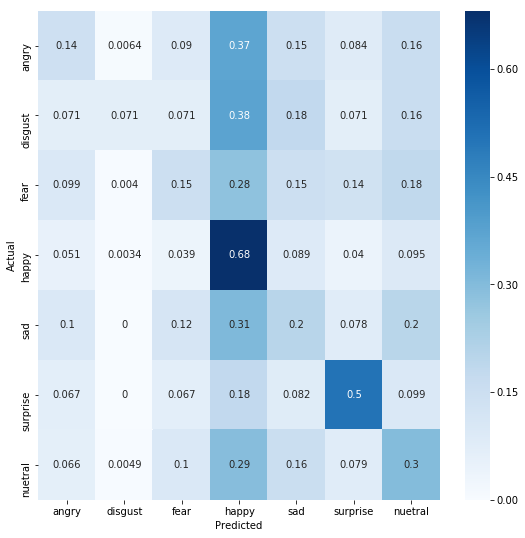

In [174]:
# Get the prediction for the testing data
y_pred_lr = lr.predict(x_testing_flat)
y_pred_lrp = lr.predict_log_proba(x_testing_flat)
# Print the accuracy of the model
print("Accuracy Score (accuracy_score): %0.2f" % accuracy_score(y_testing_flat, y_pred_lr))
# Print the cross entripy of the model
print("Cross Entripy (log_loss): %0.2f" % log_loss(y_testing, lr.predict_proba(x_testing_flat)))
# Get the confusion matrix and normalize it
cm = confusion_matrix(y_testing_flat, y_pred_lr)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# Turn it into a dataframe
df_cm = pd.DataFrame(cm, emotions, emotions)
# Plot it using a heatmap
plt.figure(figsize=(9,9))
sn.heatmap(df_cm, annot=True,cmap="Blues")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

[2 Marks] d. Classify the faces using a support vector machine and report your accuracy.

In [117]:
# Transform the data
training_x_pca = pca.transform(x_training_flat)
testing_x_pca = pca.transform(x_testing_flat)

# Instantiate Logistic Regression Classification
svc = SVC(probability=True)
# Train the model using our training data
svc.fit(training_x_pca, y_training_flat)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
  kernel='rbf', max_iter=-1, probability=True, random_state=None,
  shrinking=True, tol=0.001, verbose=False)

Visualize the results of your classifier on the test set using a confusion matrix. Describe briefly how the multi-class nature of the problem is treated by the classifier.
<pre>
Not natively multiclass so it uses One-Vs-One. It will classify every class against one another. Given N classes, One-Vs-One classifier will produce 
</pre>
$$N(N-1)/2$$
<pre>
binary classifiers where N is the number of classes. Once this is done, given any input, any label assigning will be done via majority vote.
</pre>

Accuracy Score (accuracy_score): 0.47
Cross Entripy (log_loss): 1.42


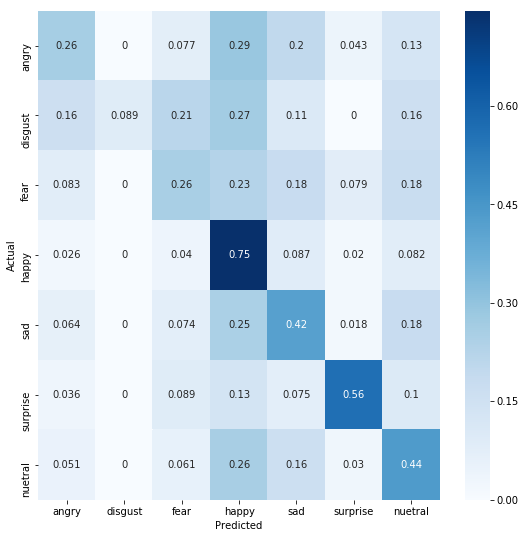

In [189]:
# Get the prediction for the testing data
y_pred_svc = svc.predict(testing_x_pca)
y_pred_svcp = svc.predict_proba(testing_x_pca)
# Print the accuracy of the model
print("Accuracy Score (accuracy_score): %0.2f" % accuracy_score(y_testing_flat, y_pred_svc))
# Print the cross entripy of the model
print("Cross Entripy (log_loss): %0.2f" % log_loss(y_testing, svc.predict_proba(testing_x_pca)))
# Get the confusion matrix and normalize it
cm = confusion_matrix(y_testing_flat, y_pred_svc)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
# Turn it into a dataframe
df_cm = pd.DataFrame(cm, emotions, emotions)
# Plot it using a heatmap
plt.figure(figsize=(9,9))
sn.heatmap(df_cm, annot=True,cmap="Blues")
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.show()

[2 Marks] e. Which categories of faces seem to be most similar or least similar?
<pre>
The following data represents the addition of feature A being mislabeled as B (as represented by the confusion matrix) and B as A. Both values are multipled by 10 to make the differences more viewable. Bigger values represent more of our model confusing the two features with one another. Optimally The highest value would be the most similar.

1 0 = 1.61
2 0 = 1.60
2 1 = 2.14
3 0 = 3.15
3 1 = 2.68
3 2 = 2.68
4 0 = 2.63
4 1 = 1.07
4 2 = 2.53
4 3 = 3.35
5 0 = 0.79
5 1 = 0.00
5 2 = 1.68
5 3 = 1.55
5 4 = 0.93
6 0 = 1.82
6 1 = 1.61
6 2 = 2.36
6 3 = 3.39
6 4 = 3.42 ***
6 5 = 1.31

The above values gives us a good metric to understand which two features are most commonly mislabeled as one other by my most reliable classifier SVC.

Furthermore, I collected data on each how often each label is being mislabeled by my SVM classifier. It is the mean of the subtraction of each column in A and B (both multiplied by 10 for viewability). The lowest value would be the two features that are mislabeled the most similarly.

0 1 = 0.69
0 2 = 1.02
0 3 = 4.01
0 4 = 1.30
0 5 = 5.18
0 6 = 2.01
1 2 = 0.41 ***
1 3 = 4.16
1 4 = 1.93
1 5 = 5.42
1 6 = 1.77
2 3 = 4.83
2 4 = 1.35
2 5 = 4.15
2 6 = 1.58
3 4 = 5.26
3 5 = 9.59
3 6 = 5.31
4 5 = 6.22
4 6 = 1.88
5 6 = 6.03

However the similarity of how they are mostly mislabeled represents the model's inconsistency and incapability to accurately predict the model. I can't imagine it implying similarity.

Because of the data above, I decided the two features that seems to be the most similar are "SAD" and "NUETRAL".
</pre>

[4 Marks] f. Let's assume that some of the faces were labeled wrong in producing the dataset. Propose and implement a solution that identifies images that are potentially mislabeled. Show 10 samples based on the method you choose.

(45,)


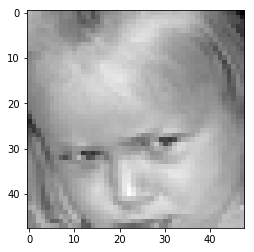

37
facial emotion: neutral


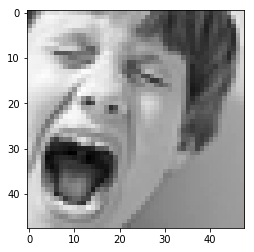

36
facial emotion: neutral


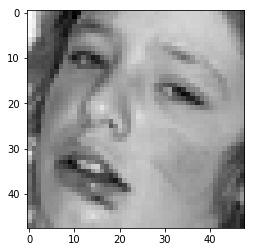

16
facial emotion: happy


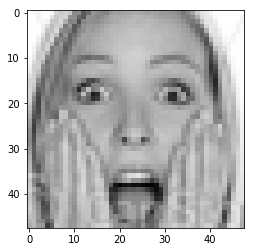

27
facial emotion: angry


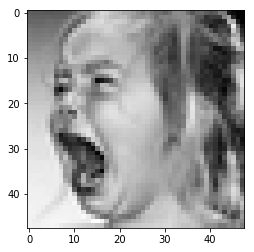

44
facial emotion: neutral


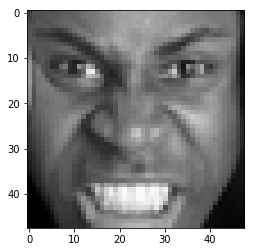

24
facial emotion: happy


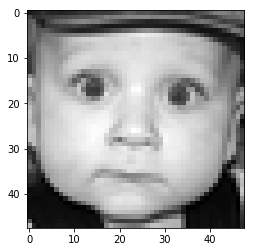

42
facial emotion: sad


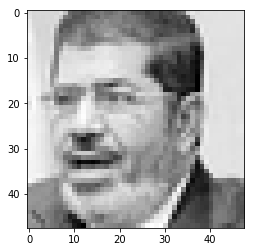

26
facial emotion: surprise


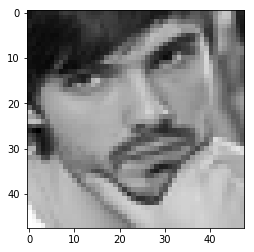

3
facial emotion: sad


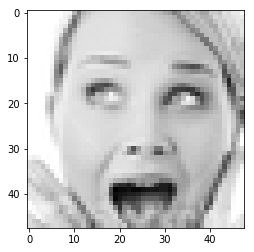

9
facial emotion: fear


In [284]:
# Get all the indices where the all classifiers disagree with the dataset results
y_qi = np.argwhere((y_testing_flat != y_pred_nb) & 
                   (y_testing_flat != y_pred_lr) & 
                   (y_testing_flat != y_pred_svc))[:,0]

# Get the values with high confidence - note that Naive Bayes wasn't put 
# into account because naive bayes has very extreme values (close to 0 or 1)
y_qip = np.array([x for x in y_qi if y_pred_svcp[x].max() > 0.70
                                 and y_pred_lrp[x].max() > -1.0])

print(y_qip.shape)
# Show 10 examples
for i in range(10):
    sampleindex = np.random.randint(0,len(y_qip))
    sample = x_testing[y_qip[sampleindex]]
    plt.imshow(sample, cmap='gray')
    plt.show()
    print(sampleindex)
    print('facial emotion: %s' % get_emotion(y_training[sampleindex, :]))

# 8318 only

From all the classification approaches considered above, choose one to score faces based on a continuous valued prediction of for each of the categories.

[6 Marks] a. Produce a prediction for each face in the test set (this has 7 dimensions). Visualize these based on a 2D embedding of the scores. The "data points" plotted in the embedding should show the actual picture of the face, at the corresponding 2D point location. (You could consider using t-SNE for your embedding)

In [ ]:
# YOUR CODE HERE